# About Dataset
Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

# Content
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

What are the benefits of PCA?

PCA can reduce the complexity and noise of the data, and highlight the most important features and relationships. For example, you can use PCA to visualize the similarities and differences between different groups of customers, products, or genes, based on multiple attributes

In [2]:
# import Libraries
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from category_encoders import OneHotEncoder
from sklearn.preprocessing import  LabelEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.linear_model import LogisticRegression
 
from sklearn.model_selection import GridSearchCV, cross_val_score,train_test_split,RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier


In [4]:
df=pd.read_csv('archive (1)/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

That's solid information. We know all our features are numerical and that we have no missing data. But,it's a good idea to do some visualizations to see if there are any interesting trends or ideas we should keep in mind while we work. First, let's take a look at how many cards are fraud and not 

In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


- the good one is that all the features are somewhat scaled except 'Time' and 'Amount'.
- as the only features which have not been transformed with PCA are 'Time' and 'Amount'.

# Explore Data

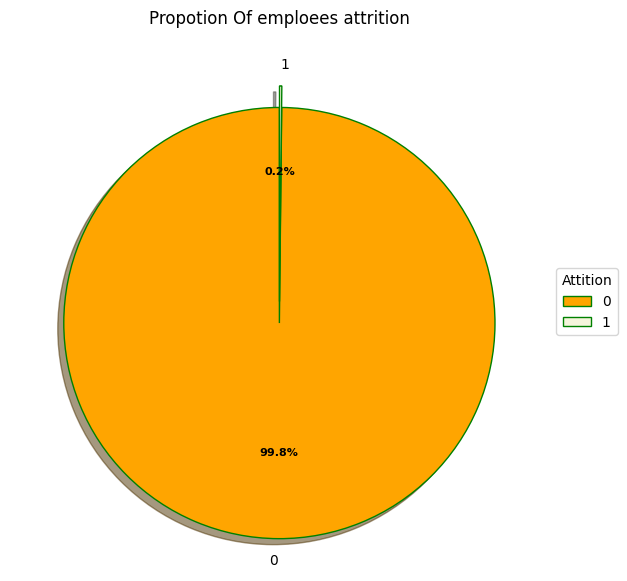

In [7]:
# Creating plot
att=df['Class'].value_counts(normalize=True)
explode = (0.1, 0.0, )
 
# Creating color parameters
colors = ( "orange", "beige")
 
# Wedge properties
wp = { 'linewidth' : 1, 'edgecolor' : "green" }
 
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%".format(pct, absolute)
 
# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(att,
                                  autopct = lambda pct: func(pct, att),
                                  explode = explode,
                                  labels = att.index,
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp,
                                  textprops = dict(color ="black"))
 
# Adding legend
ax.legend(wedges, att.index,
          title ="Attition",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
 
plt.setp(autotexts, size = 8, weight ="bold")
ax.set_title("Propotion Of emploees attrition")
 
# show plot
plt.show()

<AxesSubplot:>

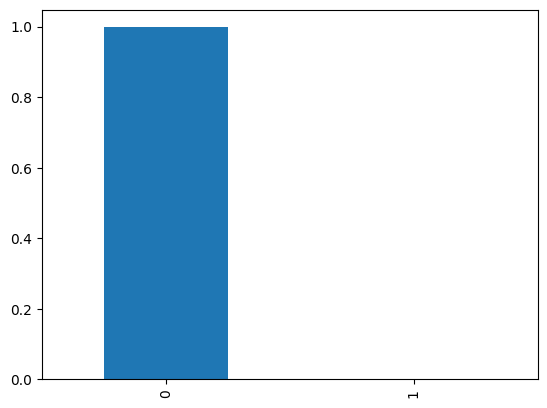

In [8]:
df['Class'].value_counts(normalize=True).plot(kind='bar')

That's good news for the banks! Since it looks like most of the credit cards in our dataset are not  fraud , let's drill down a little farther. However, it also shows us that we have an **imbalanced** dataset, where our majority class is far bigger than our minority class.

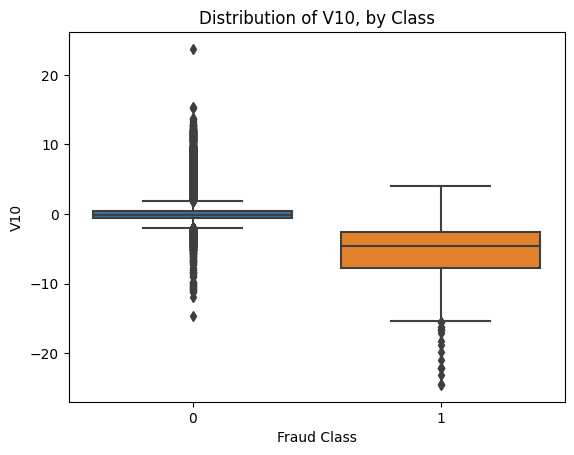

In [9]:
# Create boxplot
sns.boxplot(y='V10',x='Class',data=df)
plt.xlabel("Fraud Class")
plt.ylabel("V10")
plt.title("Distribution of V10, by Class");

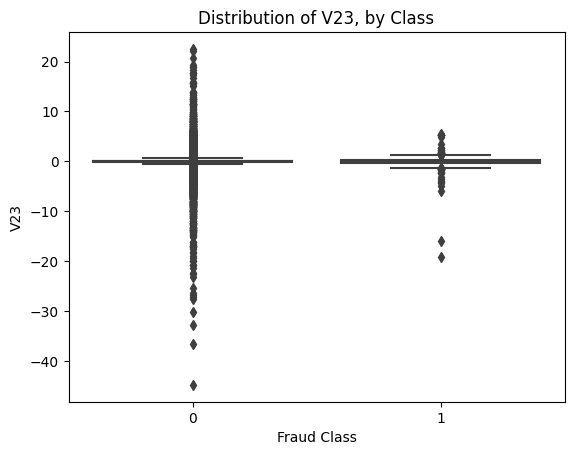

In [10]:
# Create boxplot
sns.boxplot(y='V23',x='Class',data=df)
plt.xlabel("Fraud Class")
plt.ylabel("V23")
plt.title("Distribution of V23, by Class");

Looking at other features, we can see that they're skewed, too. This will be important to keep in mind when we decide what type of model we want to use.

Another important consideration for model selection is whether there are any issues with multicollinearity in our model. Let's check.

<AxesSubplot:>

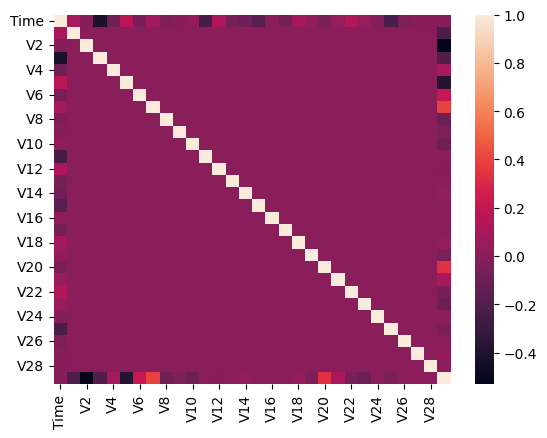

In [11]:
corr=df.drop(columns='Class').corr()
sns.heatmap(corr)

- There is no relationship between columns 
- it's understanding as the PCA gets features like this 

In [12]:
# Normalize Time and Amount 
scaler = StandardScaler()
 
df_scaled = scaler.fit_transform(df[['Time','Amount']].to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=['scaled_Time','scaled_Amount'])
df.drop(columns=['Time','Amount'],inplace=True)
df=pd.concat([df,df_scaled],axis=1)
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_Time,scaled_Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,-1.996583,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-1.996583,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,-1.996562,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,-1.996562,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-1.996541,-0.073403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0,1.641931,-0.350151
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,1.641952,-0.254117
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,1.641974,-0.081839
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0,1.641974,-0.313249


# Split

In [13]:
target = "Class"
X = df.drop(columns=target)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (284807, 30)
y shape: (284807,)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (227845, 30)
y_train shape: (227845,)
X_test shape: (56962, 30)
y_test shape: (56962,)


# Resample

Now that we've split our data into training and validation sets, we can address the class imbalance we saw during our EDA. One strategy is to resample the training data. There are many to do this, so let's start with under-sampling.

In [15]:
under_sampler =RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under_sampler.fit_resample(X_train,y_train)
print(X_train_under.shape)
X_train_under.head()

(788, 30)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,scaled_Time,scaled_Amount
106396,1.284213,-0.501464,-0.357034,-2.105217,-0.438960,-1.008206,0.096926,-0.295436,1.930483,-1.638090,...,-0.202416,-0.393263,-0.207654,-0.405794,0.817223,-0.851350,0.059367,0.023643,-0.523581,-0.125298
238046,0.155404,-0.039331,-0.563432,-0.478156,0.985475,0.859321,0.577935,0.379662,0.023975,-0.401163,...,0.507181,1.405727,0.137711,-1.434481,-0.521119,-0.049328,0.049098,-0.030566,1.151619,-0.003277
107344,1.135878,0.029953,0.323076,1.133289,-0.174560,0.004576,-0.148293,0.061964,0.283051,0.013872,...,0.195802,0.553511,-0.213152,-0.424880,0.640881,-0.125404,0.034163,0.021453,-0.514253,-0.178673
274061,1.992833,0.144782,-1.618801,1.410094,0.373586,-1.152419,0.642564,-0.402493,0.258189,0.260896,...,0.056648,0.332903,-0.013404,-0.017312,0.438219,-0.490139,-0.020661,-0.059648,1.495600,-0.245281
271673,-0.385451,0.672831,0.987344,-0.948938,0.740487,-0.150095,1.075317,-0.279940,0.370106,-0.805037,...,0.008414,0.307288,-0.567814,0.657006,1.060964,0.270908,-0.389675,-0.300019,1.471320,-0.313249


In [16]:
# And thin over sampler 
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)
print(X_train_over.shape)
X_train_over.head()

(454902, 30)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,scaled_Time,scaled_Amount
0,1.955041,-0.380783,-0.315013,0.330155,-0.509374,-0.086197,-0.627978,0.035994,1.054560,-0.030441,...,0.238197,0.968305,0.053208,-0.278602,-0.044999,-0.216780,0.045168,-0.047145,1.022112,-0.313289
1,-0.400975,-0.626943,1.555339,-2.017772,-0.107769,0.168310,0.017959,-0.401619,0.040378,0.611115,...,-0.153485,0.421703,0.113442,-1.004095,-1.176695,0.361924,-0.370469,-0.144792,0.470837,-0.169717
2,0.072509,0.820566,-0.561351,-0.709897,1.080399,-0.359429,0.787858,0.117276,-0.131275,-0.638222,...,-0.314638,-0.872959,0.083391,0.148178,-0.431459,0.119690,0.206395,0.070288,1.152945,-0.305292
3,-0.535045,1.014587,1.750679,2.769390,0.500089,1.002270,0.847902,-0.081323,0.371579,0.560595,...,0.063525,0.443431,-0.072754,0.448192,-0.655203,-0.181038,-0.093013,-0.064931,-0.024087,0.116306
4,-4.026938,1.897371,-0.429786,-0.029571,-0.855751,-0.480406,-0.435632,1.313760,0.536044,1.221746,...,-0.480691,-0.230369,0.250717,0.066399,0.470787,0.245335,0.286904,-0.322672,-0.256040,-0.250239


# Build Model

## base line

In [17]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9983


## 1- Random Forest Classifier

In [22]:
tuned_hyper_model= RandomForestClassifier(n_estimators = 100, max_depth = 3, random_state = 1234)
tuned_hyper_model_over= RandomForestClassifier(n_estimators = 100, max_depth = 3, random_state = 1234)
tuned_hyper_model_under= RandomForestClassifier(n_estimators = 100, max_depth = 3, random_state = 1234)

In [23]:
tuned_hyper_model.fit(X_train,y_train)

RandomForestClassifier(max_depth=3, random_state=1234)

In [24]:
tuned_hyper_model_over.fit(X_train_over,y_train_over)

RandomForestClassifier(max_depth=3, random_state=1234)

In [25]:
tuned_hyper_model_under.fit(X_train_under,y_train_under)

RandomForestClassifier(max_depth=3, random_state=1234)

## Evaluate 

In [26]:
for m in [tuned_hyper_model, tuned_hyper_model_over, tuned_hyper_model_under]:
    acc_train = m.score(X_train,y_train)
    acc_test = m.score(X_test,y_test)

    print("Training Accuracy:", round(acc_train, 4))
    print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 0.9992
Test Accuracy: 0.9992
Training Accuracy: 0.9941
Test Accuracy: 0.9943
Training Accuracy: 0.9937
Test Accuracy: 0.9941


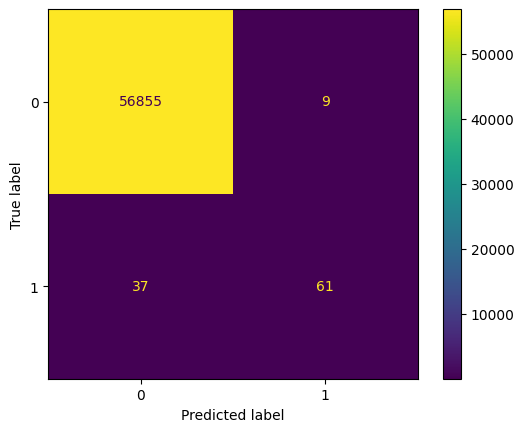

In [27]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(tuned_hyper_model,X_test,y_test)

**Thanks for reading**